In [6]:
# preiau setul de date de pe platforma Hugging Face
# link: https://huggingface.co/datasets/ro_sent

!pip install datasets stop-words skl2onnx onnxruntime
!python -m spacy download ro_core_news_sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
  Using cached https://github.com/explosion/spacy-models/releases/download/ro_core_news_sm-3.5.0/ro_core_news_sm-3.5.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')


In [7]:
from datasets import load_dataset

import pandas as pd
import re
import spacy

from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

import onnxruntime

from stop_words import get_stop_words

In [8]:
set_date = load_dataset('ro_sent')         # preiau setul de date "ro_sent"

train_df = set_date['train'].to_pandas()   # date de antrenare
test_df = set_date['test'].to_pandas()     # date de test

train_df

  0%|          | 0/2 [00:00<?, ?it/s]

,original_id,id,sentence,label
0,0,0,acest document mi-a deschis cu adevarat ochii ...,1
1,1,1,tine mancarea rece. ce altceva ii mai trebuie?...,1
2,2,2,excelent\nrecomand!,1
3,3,3,"ca un rocker imbatranit, acest film mentioneaz...",1
4,4,4,"ei bine, a facut o groaza veche si foarte intu...",1
...,...,...,...,...
17936,6842,17936,grija la notificari\ncand am cumparat telefonu...,0
17937,6843,17937,sotia mea si cu mine imi place sa inchiriem fi...,0
17938,6844,17938,nu stiu cum puteti da calificative si stele un...,0
17939,6845,17939,tradarea vine din insasi citirea ceatiei. vezi...,0


In [9]:
# am observat că datele au două atribute care nu îmi sunt de folos: 'original_id' și 'id', pe care le voi scoate, pentru a facilita modul de lucru

atribute = ['original_id', 'id']

train_df = train_df.drop(columns = atribute)
test_df = test_df.drop(columns = atribute)

test_df   # coloana 'sentence' conține textul, iar coloana 'label' spune dacă textul conține o recenzie pozitivă (1) sau negativă(0)

,sentence,label
0,am vazut recent episoadele 1-4 si acum nu pot ...,1
1,anii cei mai buni ai vietii noastre capteaza p...,1
2,"aceasta apartine in clasa lor superioara, desi...",1
3,lucrare stralucitoare. actorii minunati se diz...,1
4,oamenii par sa se astepte la citizen kane aici...,1
...,...,...
11000,"toate filmele care contin ""efecte sonore gooas...",0
11001,pentru o buna preluare a imperiului roman vizi...,0
11002,nu mi-a placut acest film. am inchiriat-o in s...,0
11003,singura parte buna a acestui film a fost sfars...,0


In [10]:
# în exemplul dat, împărțirea datelor este: ~62% train și ~38% test; voi concatena aceste seturi și voi face alte verificări,iar apoi voi împărți în alt mod datele

total_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

total_df.info()  # toate datele nu conțin valori nule
print()
total_df['label'].value_counts()   # sunt 11675 recenzii negative și 17271 pozitive, deci distribuția nu este una echilibrată

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28946 entries, 0 to 28945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  28946 non-null  object
 1   label     28946 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 452.4+ KB



1    17271
0    11675
Name: label, dtype: int64

In [ ]:
# în primă instanță voi împărți datele în 80% train și 20% test și voi testa pentru mai multe modele
# apoi, voi alege aleatoriu 11675 din cele 17271 de recenzii pozitive, cu scopul de a balansa numărul de sample-uri pentru fiecare din cele 2 clase

text_train , text_test , label_train , label_test = train_test_split(total_df.drop('label',axis = 1) , total_df.label,test_size = 0.2 , random_state = 42)

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , MultinomialNB())
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , LogisticRegression())
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , KNeighborsClassifier())
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , RandomForestClassifier())
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , XGBClassifier())
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
# undersampling

b_text_train , b_text_test , b_label_train , b_label_test = train_test_split(
        total_df.drop('label',axis = 1), total_df.label,test_size = 0.2 , random_state = 42)

total_df_balansat = pd.concat([b_text_train, b_label_train], axis=1)

negativ_sample = total_df_balansat[total_df_balansat['label'] == 0]
pozitiv_sample = total_df_balansat[total_df_balansat['label'] == 1]

# voi alege aleator din recenziile pozitive, cu scopul de a balansa numărul de sample-uri
# random_state setat pentru a obține același rezultat la fiecare rulare
pozitiv_sample = pozitiv_sample.sample(n = len(negativ_sample), random_state=42)

total_df_balansat = pd.concat([pozitiv_sample, negativ_sample], axis=0, ignore_index=True)

# pentru a păstra efectul aleator, voi amesteca datele concatenate
total_df_balansat = total_df_balansat.sample(frac=1, random_state=42)

b_text_train = total_df_balansat['sentence']
b_label_train = total_df_balansat['label']

# acum distribuția este echilibrată, 11675 recenzii din ambele categorii
total_df_balansat['label'].value_counts()

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , MultinomialNB())
print("Medie cross validation "+ str(cross_val_score(pipe, b_text_train , b_label_train, cv=5).mean()))
pipe.fit(b_text_train , b_label_train)
print("Acuratete train " + str(pipe.score(b_text_train , b_label_train)))
b_label_pred = pipe.predict(b_text_test.sentence)
print("Acuratete test " + str(accuracy_score(b_label_pred, b_label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , LogisticRegression())
print("Medie cross validation "+ str(cross_val_score(pipe, b_text_train , b_label_train, cv=5).mean()))
pipe.fit(b_text_train , b_label_train)
print("Acuratete train " + str(pipe.score(b_text_train , b_label_train)))
b_label_pred = pipe.predict(b_text_test.sentence)
print("Acuratete test " + str(accuracy_score(b_label_pred, b_label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , KNeighborsClassifier())
print("Medie cross validation "+ str(cross_val_score(pipe, b_text_train , b_label_train, cv=5).mean()))
pipe.fit(b_text_train , b_label_train)
print("Acuratete train " + str(pipe.score(b_text_train , b_label_train)))
b_label_pred = pipe.predict(b_text_test.sentence)
print("Acuratete test " + str(accuracy_score(b_label_pred, b_label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , RandomForestClassifier())
print("Medie cross validation "+ str(cross_val_score(pipe, b_text_train , b_label_train, cv=5).mean()))
pipe.fit(b_text_train , b_label_train)
print("Acuratete train " + str(pipe.score(b_text_train , b_label_train)))
b_label_pred = pipe.predict(b_text_test.sentence)
print("Acuratete test " + str(accuracy_score(b_label_pred, b_label_test)))

In [ ]:
pipe = make_pipeline(TfidfVectorizer(stop_words=None) , XGBClassifier())
print("Medie cross validation "+ str(cross_val_score(pipe, b_text_train , b_label_train, cv=5).mean()))
pipe.fit(b_text_train , b_label_train)
print("Acuratete train " + str(pipe.score(b_text_train , b_label_train)))
b_label_pred = pipe.predict(b_text_test.sentence)
print("Acuratete test " + str(accuracy_score(b_label_pred, b_label_test)))

In [ ]:
# oversampling

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('smote', SMOTE(random_state=42)),
    ('clf', MultinomialNB())
])
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression())
])
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier())
])
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier())
])
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier())
])
print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [11]:
# preprocesări

stopwords_ro = get_stop_words('romanian')
stemmer = SnowballStemmer('romanian')
nlp = spacy.load('ro_core_news_sm')

# elimin caracterele speciale și normalizez space-urile
def elimina_char_speciale(texts):
    elim_caract_spec = [re.sub(r"[^a-zA-Z]"," ", text) for text in texts]
    return [re.sub(r"\s+"," ",text) for text in elim_caract_spec]

# elimin cuvintele care nu contribuie semnificativ la înțelegerea textului
def elimina_stopwords(texts):
    continut = []
    
    for sentence in texts:
        string = ""
        
        for word in sentence.split(" "):
            if word.strip() in stopwords_ro:
                continue
            else:
                string = string + " " + word
                
        continut.append(string)
    
    return continut
    
# stemming
def stematizare(text):
    stems = []
    for token in text.split():
        stems.append(stemmer.stem(token))
        
    return " ".join(stems)

# lemming
def lematizare(text):
    tokens = nlp(text)
    
    lemmas = []
    for token in tokens:
        lemmas.append(token.lemma_)
        
    return " ".join(lemmas)

In [ ]:
for lemming in [False, True]:
    for stemming in [False, True]:
        for stop_words in [False, True]:
            for char_spec in [False, True]:
                total_df_pre = total_df
                
                if (char_spec):
                    print("\nchar_speciale", end="")
                    total_df_pre.sentence = elimina_char_speciale(total_df_pre.sentence.values)
                if (stop_words):
                    if (char_spec):
                        print(" + stop_words", end="")
                    else:
                        print("\nstop_words", end="")
                    total_df_pre.sentence = elimina_stopwords(total_df_pre.sentence.values)
                if (stemming):
                    if (char_spec or stop_words):
                        print(" + stemming", end="")
                    else:
                        print("\nstemming", end="")
                    total_df_pre.sentence = total_df_pre.sentence.apply(lambda x: stematizare(x))
                if (lemming):
                    if (char_spec or stop_words or stemming):
                        print(" + lemming", end="")
                    else:
                        print("\nlemming", end="")
                    total_df_pre.sentence = total_df_pre.sentence.apply(lambda x: lematizare(x))
                
                # împart datele
                text_train , text_test , label_train , label_test = train_test_split(total_df_pre.drop('label',axis = 1),
                                                                        total_df_pre.label,test_size = 0.2 , random_state = 42)

                print("\nLogistic Regression\")
                
                pipe = make_pipeline(TfidfVectorizer(stop_words=None) , LogisticRegression(random_state = 42))
                print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
                pipe.fit(text_train.sentence , label_train)
                print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
                label_pred = pipe.predict(text_test.sentence)
                print("Acuratete test " + str(accuracy_score(label_pred, label_test)))
                      
                print("\nXGBClassifier\")
                
                pipe = make_pipeline(TfidfVectorizer(stop_words=None) , XGBClassifier(random_state = 42))
                print("Medie cross validation "+ str(cross_val_score(pipe, text_train.sentence , label_train, cv=5).mean()))
                pipe.fit(text_train.sentence , label_train)
                print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
                label_pred = pipe.predict(text_test.sentence)
                print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

In [12]:
# aplic preprocesările pe setul de date

total_df_pre = total_df

total_df_pre.sentence = elimina_char_speciale(total_df_pre.sentence.values)
total_df_pre.sentence = total_df_pre.sentence.apply(lambda x: stematizare(x))
                
# împart datele
text_train , text_test , label_train , label_test = train_test_split(
    total_df_pre.drop('label',axis = 1), total_df_pre.label,test_size = 0.2 , random_state = 42)

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('logreg', LogisticRegression(random_state = 42))
])
parametrii = {'tfidf__ngram_range' : [(1, 1), (1, 2), (2, 2)],
              'logreg__C' : [1, 2, 3]
              'logreg__penalty' : ['l1', 'l2', 'elasticnet'],
              'logreg__max_iter' : [100, 150, 200]
             }
grid_search_pipeline = GridSearchCV(pipe, parametrii, cv=5, scoring='accuracy')
grid_search_pipeline.fit(text_train.sentence , label_train)
print(grid_search_pipeline.best_params_, grid_search_pipeline.best_score_)

In [ ]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
    ('logreg', LogisticRegression(random_state = 42, max_iter=200))
])
parametrii = {'logreg__C' : list(range(3,20))}
grid_search_pipeline = GridSearchCV(pipe, parametrii, cv=5, scoring='accuracy')
grid_search_pipeline.fit(text_train.sentence , label_train)
print(grid_search_pipeline.best_params_, grid_search_pipeline.best_score_)

In [13]:
def matrice_confuzie(label_pred, label_test):
    cm = confusion_matrix(label_test, label_pred)
    display_cm = ConfusionMatrixDisplay(cm, display_labels=["Recenzie negativă","Recenzie pozitivă"])
    display_cm.plot()
    plt.title("Matrice de confuzie")
    plt.show()

Acuratete train 0.9990067369148384
Acuratete test 0.8972366148531952


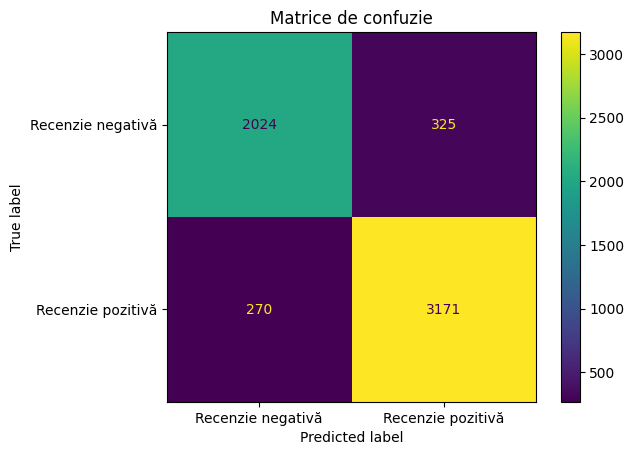

In [14]:
# model final

pipe = make_pipeline(TfidfVectorizer(stop_words=None, ngram_range=(1,2)) , LogisticRegression(random_state = 42, max_iter=200, C=18))
pipe.fit(text_train.sentence , label_train)
print("Acuratete train " + str(pipe.score(text_train.sentence , label_train)))
label_pred = pipe.predict(text_test.sentence)
print("Acuratete test " + str(accuracy_score(label_pred, label_test)))

matrice_confuzie(label_pred, label_test)

In [15]:
# exportarea modelului final

initial_type = [('recenzie', StringTensorType([None, 1]))]

converted_model = convert_sklearn(pipe , initial_types=initial_type)
with open("model_ml.onnx", "wb") as f:
    f.write(converted_model.SerializeToString())

In [10]:
# testez pentru o recenzie, ca exemplu
exemple = []
exemple.append("Aluatul prost frământat și necopt era aproape topit in balta lăsată de grămada de legume, neîngrijit ornata peste pizza aproape fără nici un gust … Am cerut furculița și cuțit ca sa pot culege pizza din cutia de la Carrefour Orhideea, unde angajații stăteau pe Instagram și se uitau la mine de parca ii sechestram din priviri. Cu alte cuvinte … o pizza mai proasta n-am servit niciodată!")
exemple.append("Cu indulgenta 3 stele, pentru salata mai mult, pastele nu aveau nici un gust iar nota finala pt ce se vede si o limonada 72 lei Dezamagitor!")
exemple.append("Platourile alea sunt foarte șmechere pt cunoscători. Păcat că nu mai este locul pt fumători cum era pe vremuri. Mulțumesc.") 
    
# transform diacriticile în literele corespunzătoare
exemple_preprocesate = []

for exemplu in exemple:
    prop = ""
    for litera in exemplu:
        match litera.lower():
            case "ă" | "â":
                prop += "a"
            case "î":
                prop += "i"
            case "ș":
                prop += "s"
            case "ț":
                prop += "t"
            case _:
                prop += litera
    exemple_preprocesate.append(prop)

# aplic aceleași preprocesări pe text
exemple_preprocesate = elimina_char_speciale(exemple_preprocesate)
exemple_preprocesate = [stematizare(x) for x in exemple_preprocesate]

# fac o predicție și arăt și scorul pe o scară de la 0 la 1 a recenziei
predictii = pipe.predict(exemple_preprocesate)
probabilitati = pipe.predict_proba(exemple_preprocesate)

for i in range(predictii.size):
    print("Label:", predictii[i], ", Scor:", probabilitati[i][1])

Label: 0 , Scor: 0.1277132349728606
Label: 0 , Scor: 0.04015152908880761
Label: 1 , Scor: 0.7110941495915393


In [16]:
exemplu = ["Aluatul prost frământat și necopt era aproape topit in balta lăsată de grămada de legume, neîngrijit ornata peste pizza aproape fără nici un gust … Am cerut furculița și cuțit ca sa pot culege pizza din cutia de la Carrefour Orhideea, unde angajații stăteau pe Instagram și se uitau la mine de parca ii sechestram din priviri. Cu alte cuvinte … o pizza mai proasta n-am servit niciodată!"]

prop = ""
for litera in exemplu[0]:
    match litera.lower():
        case "ă" | "â":
            prop += "a"
        case "î":
            prop += "i"
        case "ș":
            prop += "s"
        case "ț":
            prop += "t"
        case _:
            prop += litera
exemplu[0] = prop

# aplic aceleași preprocesări pe text
exemplu = elimina_char_speciale(exemplu)
exemplu = [stematizare(exemplu[0])]

# fac o predicție și arăt și scorul pe o scară de la 0 la 1 a recenziei
predictie = pipe.predict(exemplu)[0]
probabilitate = pipe.predict_proba(exemplu)[0][1]

print("Label:", predictie, ", Scor:", probabilitate)

Label: 0 , Scor: 0.1277132349728606
